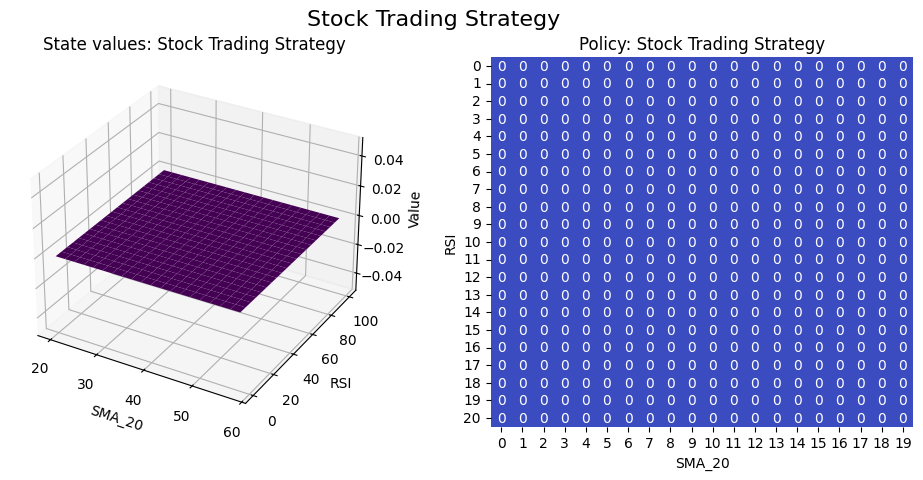

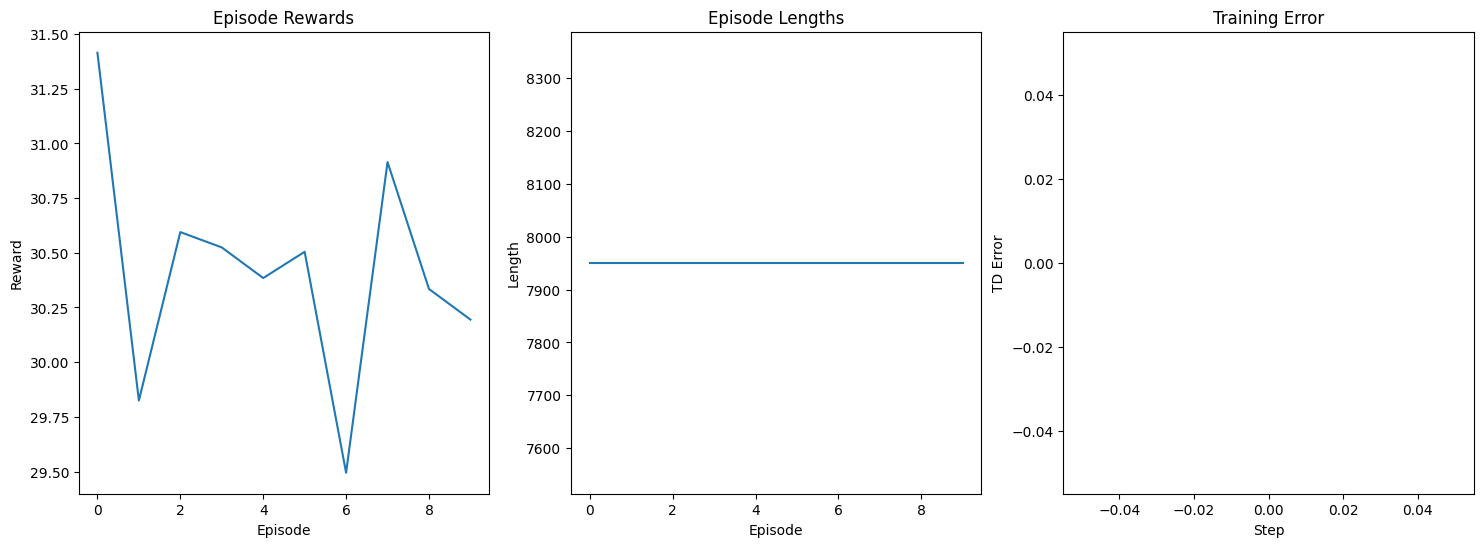

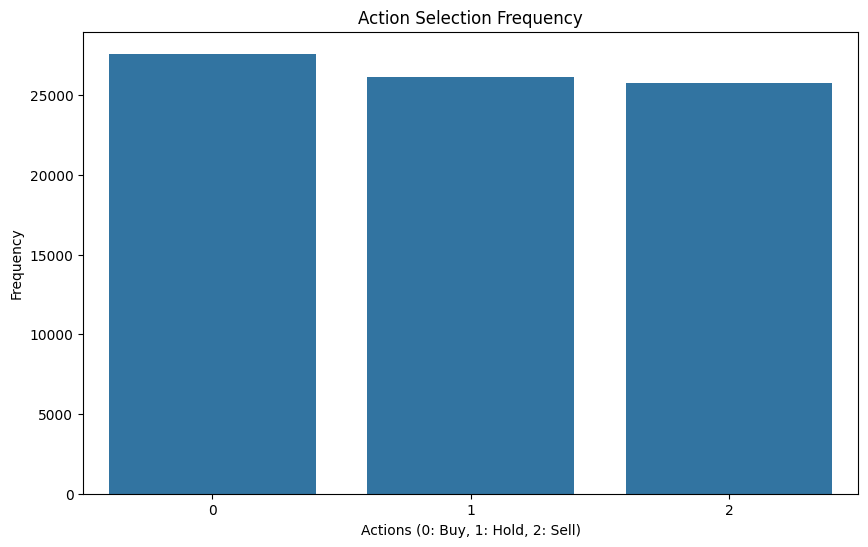

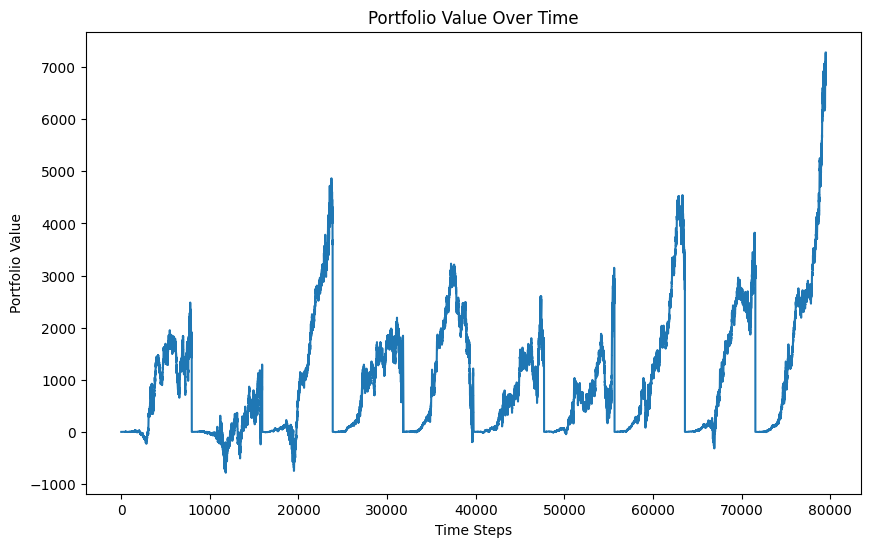

In [1]:
import pandas as pd
import numpy as np
from collections import defaultdict, deque
import matplotlib.pyplot as plt
import seaborn as sns
import random

# テキストファイルからデータを読み込む関数
def read_txt_file(file_path):
    return pd.read_csv(file_path, delimiter=',', header=0)

# ファイルパスの指定
file_path_msft = './data/msft.us.txt'  # 例としてMicrosoft Corp.のデータ

# テキストファイルを読み込む
stock_data_msft = read_txt_file(file_path_msft)

# データの前処理
def preprocess_data(stock_data):
    stock_data['Date'] = pd.to_datetime(stock_data['Date'])
    stock_data.set_index('Date', inplace=True)
    stock_data.sort_index(inplace=True)
    
    # 必要な特徴量の計算
    def compute_rsi(series, window=14):
        delta = series.diff(1)
        gain = (delta.where(delta > 0, 0)).rolling(window=window).mean()
        loss = (-delta.where(delta < 0, 0)).rolling(window=window).mean()
        rs = gain / loss
        return 100 - (100 / (1 + rs))

    stock_data['SMA_20'] = stock_data['Close'].rolling(window=20).mean()  # 20日移動平均
    stock_data['RSI'] = compute_rsi(stock_data['Close'])  # RSIの計算
    stock_data['MACD'] = stock_data['Close'].ewm(span=12, adjust=False).mean() - stock_data['Close'].ewm(span=26, adjust=False).mean()  # MACD
    stock_data['Upper_BB'] = stock_data['Close'].rolling(window=20).mean() + (stock_data['Close'].rolling(window=20).std() * 2)  # ボリンジャーバンド上限
    stock_data['Lower_BB'] = stock_data['Close'].rolling(window=20).mean() - (stock_data['Close'].rolling(window=20).std() * 2)  # ボリンジャーバンド下限

    # NaNを削除
    stock_data.dropna(inplace=True)
    return stock_data

# データの前処理
stock_data_msft = preprocess_data(stock_data_msft)

# 状態空間と行動空間の定義
states = [(sma, rsi, macd, bb_upper, bb_lower) for sma in range(20, 60, 2) for rsi in range(0, 101, 5) for macd in range(-5, 6, 1) for bb_upper in range(-5, 6, 1) for bb_lower in range(-5, 6, 1)]
actions = [0, 1, 2]  # 0: Buy, 1: Hold, 2: Sell

class QLearningAgent:
    def __init__(self, alpha=0.1, gamma=0.9, epsilon=1.0, epsilon_decay=0.995, epsilon_min=0.01, memory_size=10000, batch_size=32):
        self.alpha = alpha
        self.gamma = gamma
        self.epsilon = epsilon
        self.epsilon_decay = epsilon_decay
        self.epsilon_min = epsilon_min
        self.q_values = defaultdict(lambda: np.zeros(len(actions)))
        self.episode_rewards = []
        self.episode_lengths = []
        self.training_errors = []
        self.action_history = []
        self.portfolio_values = []
        self.memory = deque(maxlen=memory_size)
        self.batch_size = batch_size
    
    def select_action(self, state):
        if np.random.random() < self.epsilon:
            return np.random.choice(actions)
        return np.argmax(self.q_values[state])
    
    def update(self, state, action, reward, next_state):
        best_next_action = np.argmax(self.q_values[next_state])
        td_target = reward + self.gamma * self.q_values[next_state][best_next_action]
        td_error = td_target - self.q_values[state][action]
        self.q_values[state][action] += self.alpha * td_error
        return td_error
    
    def store_transition(self, state, action, reward, next_state):
        self.memory.append((state, action, reward, next_state))
    
    def experience_replay(self):
        if len(self.memory) < self.batch_size:
            return
        batch = random.sample(self.memory, self.batch_size)
        for state, action, reward, next_state in batch:
            self.update(state, action, reward, next_state)
    
    def decay_epsilon(self):
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

# ステップ関数
def step(state, action, stock_data, t, portfolio_value):
    # 次の状態に遷移
    next_state = (
        int(stock_data.iloc[t + 1]['SMA_20']),
        int(stock_data.iloc[t + 1]['RSI']),
        int(stock_data.iloc[t + 1]['MACD']),
        int(stock_data.iloc[t + 1]['Upper_BB']),
        int(stock_data.iloc[t + 1]['Lower_BB'])
    )
    
    # 報酬の計算（取引コストを考慮）
    reward = stock_data.iloc[t + 1]['Close'] - stock_data.iloc[t]['Close']
    if action == 0:  # Buy
        reward -= 0.01  # 取引コスト
        portfolio_value += stock_data.iloc[t + 1]['Close']
    elif action == 2:  # Sell
        reward -= 0.01  # 取引コスト
        portfolio_value -= stock_data.iloc[t + 1]['Close']
    
    return next_state, reward, portfolio_value

# エージェントの訓練
agent = QLearningAgent()
num_episodes = 5  # エピソード数を増やす

for episode in range(num_episodes):
    total_reward = 0
    episode_length = 0
    portfolio_value = 0  # ポートフォリオの初期価値
    stock_data = stock_data_msft
    state = (
        int(stock_data.iloc[0]['SMA_20']),
        int(stock_data.iloc[0]['RSI']),
        int(stock_data.iloc[0]['MACD']),
        int(stock_data.iloc[0]['Upper_BB']),
        int(stock_data.iloc[0]['Lower_BB'])
    )
    for t in range(1, len(stock_data) - 1):
        action = agent.select_action(state)
        next_state, reward, portfolio_value = step(state, action, stock_data, t, portfolio_value)
        agent.store_transition(state, action, reward, next_state)
        total_reward += reward
        episode_length += 1
        state = next_state
        agent.action_history.append(action)
        agent.portfolio_values.append(portfolio_value)
    agent.experience_replay()
    agent.episode_rewards.append(total_reward)
    agent.episode_lengths.append(episode_length)
    agent.decay_epsilon()

# 学習結果の可視化
def create_grids(agent):
    state_value = defaultdict(float)
    policy = defaultdict(int)
    for obs, action_values in agent.q_values.items():
        state_value[obs] = float(np.max(action_values))
        policy[obs] = int(np.argmax(action_values))

    sma_values = range(20, 60, 2)
    rsi_values = range(0, 101, 5)
    sma_grid, rsi_grid = np.meshgrid(sma_values, rsi_values)

    value = np.apply_along_axis(
                lambda obs: state_value[(obs[0], obs[1], 0, 0, 0)],  # MACD, BB上限, BB下限は0に固定
        axis=2,
        arr=np.dstack([sma_grid, rsi_grid])
    )
    value_grid = sma_grid, rsi_grid, value

    policy_grid = np.apply_along_axis(
        lambda obs: policy[(obs[0], obs[1], 0, 0, 0)],  # MACD, BB上限, BB下限は0に固定
        axis=2,
        arr=np.dstack([sma_grid, rsi_grid])
    )
    return value_grid, policy_grid

def create_plots(value_grid, policy_grid, title: str):
    sma_grid, rsi_grid, value = value_grid
    fig = plt.figure(figsize=plt.figaspect(0.4))
    fig.suptitle(title, fontsize=16)

    ax1 = fig.add_subplot(1, 2, 1, projection="3d")
    ax1.plot_surface(sma_grid, rsi_grid, value, rstride=1, cstride=1, cmap="viridis", edgecolor="none")
    ax1.set_title(f"State values: {title}")
    ax1.set_xlabel("SMA_20")
    ax1.set_ylabel("RSI")
    ax1.set_zlabel("Value")

    ax2 = fig.add_subplot(1, 2, 2)
    sns.heatmap(policy_grid, linewidth=0, annot=True, cmap="coolwarm", cbar=False, ax=ax2)
    ax2.set_title(f"Policy: {title}")
    ax2.set_xlabel("SMA_20")
    ax2.set_ylabel("RSI")

    return fig

value_grid, policy_grid = create_grids(agent)
fig = create_plots(value_grid, policy_grid, title="Stock Trading Strategy")
plt.show()

# エピソードごとの報酬、エピソードの長さ、訓練エラーのプロット
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 6))

ax1.plot(agent.episode_rewards)
ax1.set_title('Episode Rewards')
ax1.set_xlabel('Episode')
ax1.set_ylabel('Reward')

ax2.plot(agent.episode_lengths)
ax2.set_title('Episode Lengths')
ax2.set_xlabel('Episode')
ax2.set_ylabel('Length')

ax3.plot(agent.training_errors)
ax3.set_title('Training Error')
ax3.set_xlabel('Step')
ax3.set_ylabel('TD Error')

plt.show()

# 行動選択の頻度のプロット
fig, ax = plt.subplots(figsize=(10, 6))
action_counts = pd.Series(agent.action_history).value_counts()
sns.barplot(x=action_counts.index, y=action_counts.values, ax=ax)
ax.set_title('Action Selection Frequency')
ax.set_xlabel('Actions (0: Buy, 1: Hold, 2: Sell)')
ax.set_ylabel('Frequency')
plt.show()

# ポートフォリオの価値変化のプロット
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(agent.portfolio_values)
ax.set_title('Portfolio Value Over Time')
ax.set_xlabel('Time Steps')
ax.set_ylabel('Portfolio Value')
plt.show()


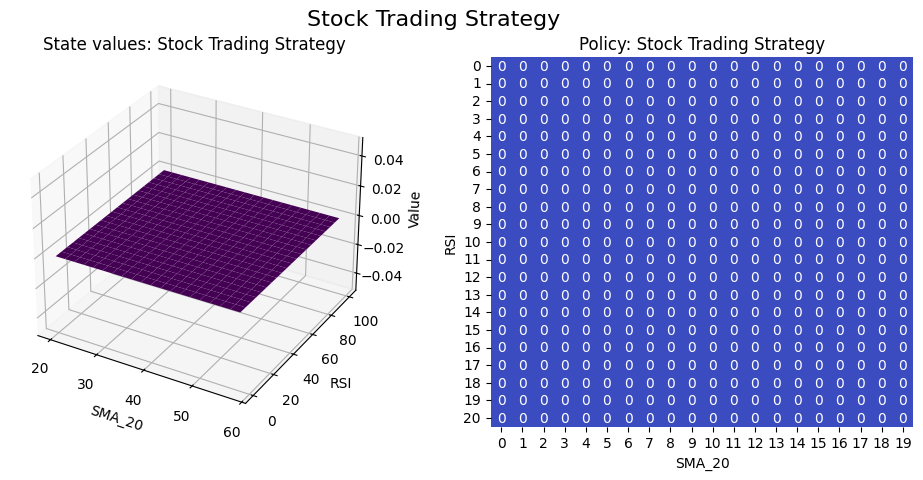

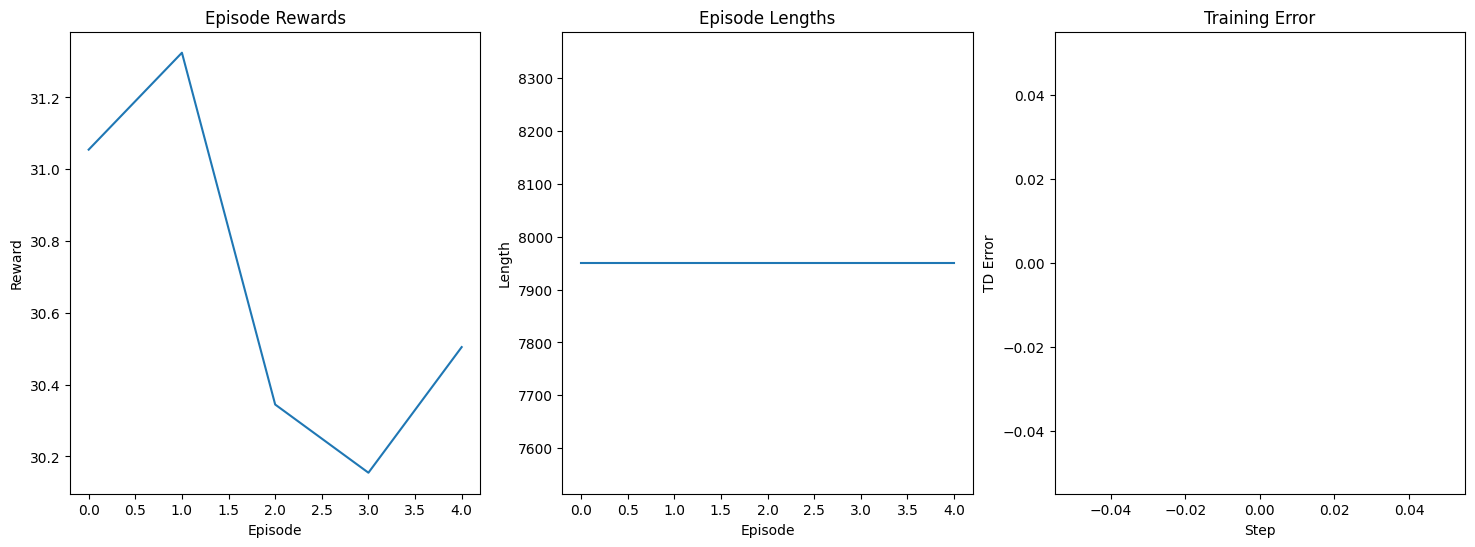

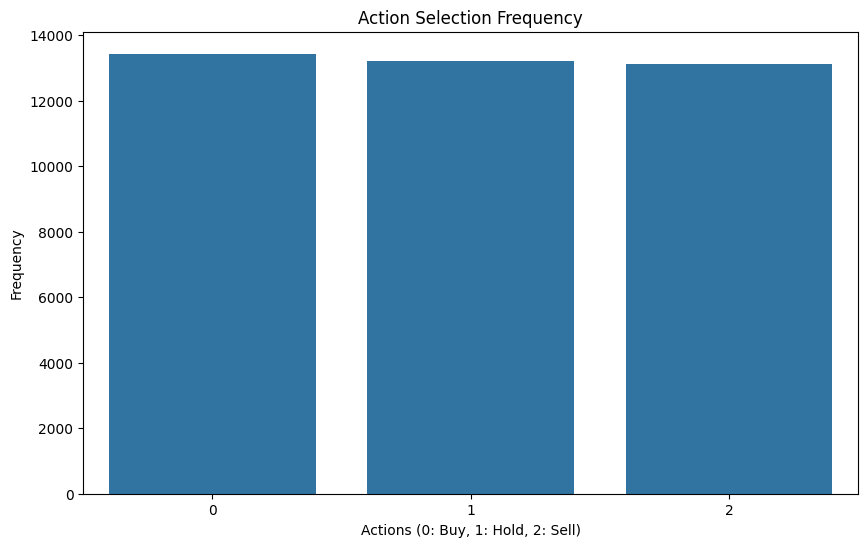

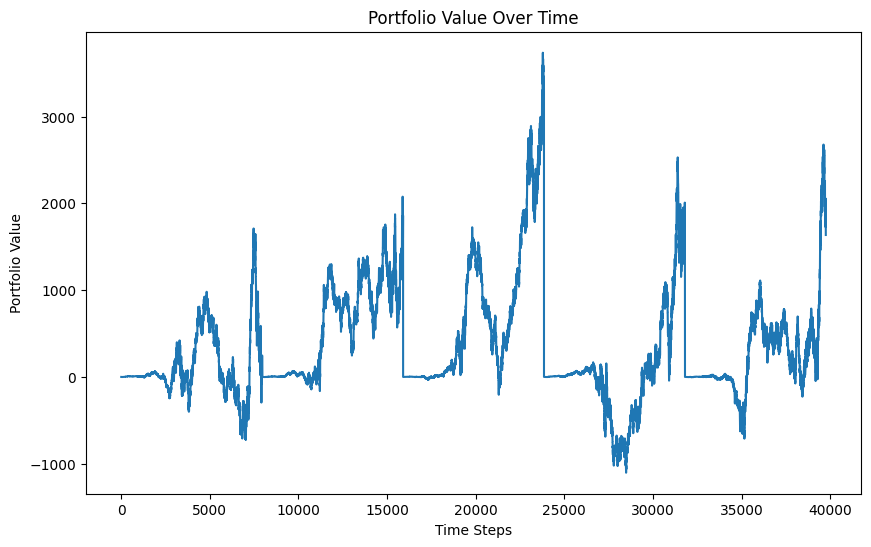

In [2]:
import pandas as pd
import numpy as np
from collections import defaultdict, deque
import matplotlib.pyplot as plt
import seaborn as sns
import random

# テキストファイルからデータを読み込む関数
def read_txt_file(file_path):
    return pd.read_csv(file_path, delimiter=',', header=0)

# ファイルパスの指定
file_path_msft = './data/msft.us.txt'  # 例としてMicrosoft Corp.のデータ

# テキストファイルを読み込む
stock_data_msft = read_txt_file(file_path_msft)

# データの前処理
def preprocess_data(stock_data):
    stock_data['Date'] = pd.to_datetime(stock_data['Date'])
    stock_data.set_index('Date', inplace=True)
    stock_data.sort_index(inplace=True)
    
    # 必要な特徴量の計算
    def compute_rsi(series, window=14):
        delta = series.diff(1)
        gain = (delta.where(delta > 0, 0)).rolling(window=window).mean()
        loss = (-delta.where(delta < 0, 0)).rolling(window=window).mean()
        rs = gain / loss
        return 100 - (100 / (1 + rs))

    stock_data['SMA_20'] = stock_data['Close'].rolling(window=20).mean()  # 20日移動平均
    stock_data['RSI'] = compute_rsi(stock_data['Close'])  # RSIの計算
    stock_data['MACD'] = stock_data['Close'].ewm(span=12, adjust=False).mean() - stock_data['Close'].ewm(span=26, adjust=False).mean()  # MACD
    stock_data['Upper_BB'] = stock_data['Close'].rolling(window=20).mean() + (stock_data['Close'].rolling(window=20).std() * 2)  # ボリンジャーバンド上限
    stock_data['Lower_BB'] = stock_data['Close'].rolling(window=20).mean() - (stock_data['Close'].rolling(window=20).std() * 2)  # ボリンジャーバンド下限

    # NaNを削除
    stock_data.dropna(inplace=True)
    return stock_data

# データの前処理
stock_data_msft = preprocess_data(stock_data_msft)

# 状態空間と行動空間の定義
states = [(sma, rsi, macd, bb_upper, bb_lower) for sma in range(20, 60, 2) for rsi in range(0, 101, 5) for macd in range(-5, 6, 1) for bb_upper in range(-5, 6, 1) for bb_lower in range(-5, 6, 1)]
actions = [0, 1, 2]  # 0: Buy, 1: Hold, 2: Sell

class QLearningAgent:
    def __init__(self, alpha=0.1, gamma=0.9, epsilon=1.0, epsilon_decay=0.995, epsilon_min=0.01, memory_size=10000, batch_size=32):
        self.alpha = alpha
        self.gamma = gamma
        self.epsilon = epsilon
        self.epsilon_decay = epsilon_decay
        self.epsilon_min = epsilon_min
        self.q_values = defaultdict(lambda: np.zeros(len(actions)))
        self.episode_rewards = []
        self.episode_lengths = []
        self.training_errors = []
        self.action_history = []
        self.portfolio_values = []
        self.memory = deque(maxlen=memory_size)
        self.batch_size = batch_size
    
    def select_action(self, state):
        if np.random.random() < self.epsilon:
            return np.random.choice(actions)
        return np.argmax(self.q_values[state])
    
    def update(self, state, action, reward, next_state):
        best_next_action = np.argmax(self.q_values[next_state])
        td_target = reward + self.gamma * self.q_values[next_state][best_next_action]
        td_error = td_target - self.q_values[state][action]
        self.q_values[state][action] += self.alpha * td_error
        return td_error
    
    def store_transition(self, state, action, reward, next_state):
        self.memory.append((state, action, reward, next_state))
    
    def experience_replay(self):
        if len(self.memory) < self.batch_size:
            return
        batch = random.sample(self.memory, self.batch_size)
        for state, action, reward, next_state in batch:
            self.update(state, action, reward, next_state)
    
    def decay_epsilon(self):
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

# ステップ関数
def step(state, action, stock_data, t, portfolio_value):
    # 次の状態に遷移
    next_state = (
        int(stock_data.iloc[t + 1]['SMA_20']),
        int(stock_data.iloc[t + 1]['RSI']),
        int(stock_data.iloc[t + 1]['MACD']),
        int(stock_data.iloc[t + 1]['Upper_BB']),
        int(stock_data.iloc[t + 1]['Lower_BB'])
    )
    
    # 報酬の計算（取引コストを考慮）
    reward = stock_data.iloc[t + 1]['Close'] - stock_data.iloc[t]['Close']
    if action == 0:  # Buy
        reward -= 0.01  # 取引コスト
        portfolio_value += stock_data.iloc[t + 1]['Close']
    elif action == 2:  # Sell
        reward -= 0.01  # 取引コスト
        portfolio_value -= stock_data.iloc[t + 1]['Close']
    
    return next_state, reward, portfolio_value

# エージェントの訓練
agent = QLearningAgent()
num_episodes = 5  # エピソード数を増やす

for episode in range(num_episodes):
    total_reward = 0
    episode_length = 0
    portfolio_value = 0  # ポートフォリオの初期価値
    stock_data = stock_data_msft
    state = (
        int(stock_data.iloc[0]['SMA_20']),
        int(stock_data.iloc[0]['RSI']),
        int(stock_data.iloc[0]['MACD']),
        int(stock_data.iloc[0]['Upper_BB']),
        int(stock_data.iloc[0]['Lower_BB'])
    )
    for t in range(1, len(stock_data) - 1):
        action = agent.select_action(state)
        next_state, reward, portfolio_value = step(state, action, stock_data, t, portfolio_value)
        agent.store_transition(state, action, reward, next_state)
        total_reward += reward
        episode_length += 1
        state = next_state
        agent.action_history.append(action)
        agent.portfolio_values.append(portfolio_value)
    agent.experience_replay()
    agent.episode_rewards.append(total_reward)
    agent.episode_lengths.append(episode_length)
    agent.decay_epsilon()

# 学習結果の可視化
def create_grids(agent):
    state_value = defaultdict(float)
    policy = defaultdict(int)
    for obs, action_values in agent.q_values.items():
        state_value[obs] = float(np.max(action_values))
        policy[obs] = int(np.argmax(action_values))

    sma_values = range(20, 60, 2)
    rsi_values = range(0, 101, 5)
    sma_grid, rsi_grid = np.meshgrid(sma_values, rsi_values)

    value = np.apply_along_axis(
                lambda obs: state_value[(obs[0], obs[1], 0, 0, 0)],  # MACD, BB上限, BB下限は0に固定
        axis=2,
        arr=np.dstack([sma_grid, rsi_grid])
    )
    value_grid = sma_grid, rsi_grid, value

    policy_grid = np.apply_along_axis(
        lambda obs: policy[(obs[0], obs[1], 0, 0, 0)],  # MACD, BB上限, BB下限は0に固定
        axis=2,
        arr=np.dstack([sma_grid, rsi_grid])
    )
    return value_grid, policy_grid

def create_plots(value_grid, policy_grid, title: str):
    sma_grid, rsi_grid, value = value_grid
    fig = plt.figure(figsize=plt.figaspect(0.4))
    fig.suptitle(title, fontsize=16)

    ax1 = fig.add_subplot(1, 2, 1, projection="3d")
    ax1.plot_surface(sma_grid, rsi_grid, value, rstride=1, cstride=1, cmap="viridis", edgecolor="none")
    ax1.set_title(f"State values: {title}")
    ax1.set_xlabel("SMA_20")
    ax1.set_ylabel("RSI")
    ax1.set_zlabel("Value")

    ax2 = fig.add_subplot(1, 2, 2)
    sns.heatmap(policy_grid, linewidth=0, annot=True, cmap="coolwarm", cbar=False, ax=ax2)
    ax2.set_title(f"Policy: {title}")
    ax2.set_xlabel("SMA_20")
    ax2.set_ylabel("RSI")

    return fig

value_grid, policy_grid = create_grids(agent)
fig = create_plots(value_grid, policy_grid, title="Stock Trading Strategy")
plt.show()

# エピソードごとの報酬、エピソードの長さ、訓練エラーのプロット
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 6))

ax1.plot(agent.episode_rewards)
ax1.set_title('Episode Rewards')
ax1.set_xlabel('Episode')
ax1.set_ylabel('Reward')

ax2.plot(agent.episode_lengths)
ax2.set_title('Episode Lengths')
ax2.set_xlabel('Episode')
ax2.set_ylabel('Length')

ax3.plot(agent.training_errors)
ax3.set_title('Training Error')
ax3.set_xlabel('Step')
ax3.set_ylabel('TD Error')

plt.show()

# 行動選択の頻度のプロット
fig, ax = plt.subplots(figsize=(10, 6))
action_counts = pd.Series(agent.action_history).value_counts()
sns.barplot(x=action_counts.index, y=action_counts.values, ax=ax)
ax.set_title('Action Selection Frequency')
ax.set_xlabel('Actions (0: Buy, 1: Hold, 2: Sell)')
ax.set_ylabel('Frequency')
plt.show()

# ポートフォリオの価値変化のプロット
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(agent.portfolio_values)
ax.set_title('Portfolio Value Over Time')
ax.set_xlabel('Time Steps')
ax.set_ylabel('Portfolio Value')
plt.show()
